## Set up

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr

## Coupled CANN

### Questions during implementation:

#### Network

##### Poisson Variability

- How Poisson Variability is represented by Eq.11 #Questions  

##### Fano Factor $F$

What is the mean and variance of the Fano Factor
Try $\sigma =a, \mu = s_m$ , due to “(C) The feedforward input is modeled as continuous approximation of Poisson spikes with Gaussian tuning over the stimulus feature.” ([Zhang et al., 2020, p. 5](zotero://select/library/items/5GZ6Z4HR)) ([pdf](zotero://open-pdf/library/items/KDU4GASG?page=5&annotation=NVNWK6G7))
- Just let $F = 1$ due to "Poisson"What is the mean and variance of the Fano Factor 

- Try $\sigma =a, \mu = s_m$ , due to “(C) The feedforward input is modeled as continuous approximation of Poisson spikes with Gaussian tuning over the stimulus feature.” ([Zhang et al., 2020, p. 5](zotero://select/library/items/5GZ6Z4HR)) ([pdf](zotero://open-pdf/library/items/KDU4GASG?page=5&annotation=NVNWK6G7))
Just let $F = 1$ due to "Poisson"

##### $\textbf{I}_m^\textrm{f}$, Feedforward input

1. “Based on the Gaussian tuning and Poisson variability (Eq. 9), the likelihood of sm given an observed Ifm is also a Gaussian distribution (Fig. 2E), i.e., $p(\textbf{I}^\textrm{f}_m|s_m) = p(x_m|s_m) = \mathcal{N} (x_xm|s_m, \Lambda^{-1}_m )$ ” (Zhang et al., 2020, p. 4)  


2. What's the relationship between $\textbf{I}_m^\textrm{f}$ and $x_m$ ?


“the probability of observing a particular value of $\textbf{I}_m^\textrm{f}$ given $s_m$ ” ([Zhang et al., 2020, p. 4](zotero://select/library/items/5GZ6Z4HR)) ([pdf](zotero://open-pdf/library/items/KDU4GASG?page=4&annotation=PQ8LA5RS))  
	- Eq. 9  
$$
	  \textbf{I}_m^\textrm{f} \mid s_m \sim  \prod_{j = 1}^N \textrm{Poisson}[\lambda_{m, j}(s_m)], \lambda_{m, j}(s_m) = \textrm{I}_m^\textrm{f} \exp[-(\theta_j - s_m)/2 a^2]
	  $$ 
3. What does the symbol $\sim$ mean? the distribution of?
    
##### Internal Poisson-like Variability  

- How Poisson Variability is represented by Eq.11 
    
##### Langevin Sampling  

- $s^{\textbf{r}}_{mt}$ in Eq.12 and $s^{\textbf{r}}_m$ in Eq.14, are they same ? 

- “DU = diag(U1, U2, · · · , UM ) and Df = diag(If1, If2, · · · , If M ) are diagonal matrices, denoting the peak value of the mean synaptic input, and the mean feedforward input in each network respectively” ([Zhang et al., 2020, p. 6](zotero://select/library/items/5GZ6Z4HR)) ([pdf](zotero://open-pdf/library/items/KDU4GASG?page=6&annotation=JBE6P2DA))  
	- Only can get either peak value or mean value at a instant time


### Implementation

In [50]:
class CoupledCANN:
    x_min = -np.pi
    x_max = np.pi
    stim_width = 2*np.pi
    # consider only two-coupled CANNs for now
    M = int(2) 
    # Recurrent Connection Matrices
    Wr = np.zeros(shape=(M,M))
    # Synaptic input(u), firing rate (r), Feedforward Connection(Wf), 
    
    def __init__(self, tau=1, N=124, a=1.0, k=0.5, R=[0.8, 0.9], Ip = [0.8, 0.9]):
        """ Constructor
        
        :param tau: time constant, defined as 1 ms
        :param N: number of neurons in each network
        :param k: global inhibition strength
        :param R: peak firing rates of each network 
        :param Ip: peak input rates of each network
        """
        self.tau, self.N, self.a, self.k, self.R, self.Ip = tau, N, a, k, R, Ip                               
        # record sampling points
        self.s = np.zeros(shape=(2,1))
        self.ss = []
                
        self.dx, self.rau = self.stim_width / self.N, self.N / self.stim_width
        
        # init firing rate (r), synaptic input (u), feedforward input (If)
        self.r = self.u = self.If = np.zeros(shape=(self.M, self.N))

        # set prefered stimuli for neurons in each network
        self.x = np.tile(((np.arange(0,self.N,1)+0.5) * self.dx + self.x_min), (self.M,1))
        
        # set F (Fano Factor) = 1, the feedforward connection strength(wf)
        self.F = 1
        self.wf = (2 / np.sqrt(3)) ** 3 * self.F
        self.sigma_s = 8 * self.a * self.F / (3*np.sqrt(3*np.pi))
        
        # set wr
        self.wr = self.set_wr()
        
        self.set_input()


    def g_theta(self, theta):
        """Gaussian function for calculating connection matrices
        :param theta: stumuli values
        """
        return np.exp(-theta**2 / 2*self.a**2) / np.sqrt(2*np.pi)
        

    def set_wr(self):
        wr = np.array([[1, -1], [-1, 1]])
        for m in range(self.M):
            for n in range(self.M):
                wr[m][n] = self.a * self.wf * wr[m][n] / (np.sqrt(2*np.pi)*self.rau * self.R[n])
        return wr
    
    def set_input(self, i=[0, 0]):
        if len(i) != self.M:
            raise ValueError("Network number not matched")
        for m in range(self.M):
            self.If[m] = self.Ip[m] * np.exp((self.x[m]-i[m])**2 / (2*self.a**2))
    
    def calc_r(self):
        for m in range(self.M):
            r = 0
            for n in range(self.M):
                self.r[m] = self.u[m]**2 / (1+self.k*self.rau* np.sum(self.u[m]**2))

    def calc_dudt(self):
        dudt = np.zeros(shape=(self.M, self.N))
        for m in range(self.M):  
            r = 0  
            for n in range(self.M):  
                r += np.convolve(self.wr[m][n]*self.g_theta(self.x[m]), self.r[n], "same")
            dudt[m] = -self.u[m] + self.rau*r[m] + self.rau * np.convolve(self.wf*self.g_theta(self.x[m]), self.If[m], "same") \
                + np.sqrt(self.tau*self.F*self.u[m]) * np.random.default_rng().normal(0, 0.1, 1)[0]
        return dudt / self.tau
    
    def calc_ds(self):
        """Langevin Sampling
        """
        # Select peak value here
        Du = np.diagflat(np.max(self.u, axis=1))
        # print("Du: ", Du)
        Df = np.diagflat(np.max(self.If, axis=1))
        # print("Df: ", Df)
        x = []
        noise = []
        for m in range(self.M):
            x.append((np.sum(self.If[m]*self.x) / np.sum(self.If[m])))
            noise.append(np.random.default_rng().normal(0, 0.1, 1)[0])
        x, noise = np.array(x).reshape(2, 1), np.array(noise).reshape(2, 1)
        ds = -self.rau*np.sqrt(2) * np.linalg.inv(self.tau * Du) \
            @ ((-self.wr@self.R + self.wf*Df)@self.s - self.wf*Df@x) \
            + (self.sigma_s * np.sqrt(np.linalg.inv(self.tau*Du))@noise)
        return ds / self.tau
        
    def step(self, dt):
        self.calc_r()
        self.u += self.calc_dudt() * dt
        self.s += self.calc_ds() * dt
        self.ss.append(self.s)
        return
        
        

## Random Walk of Langevin Sampling

[array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.20480207e+37],
       [3.02181286e+38]]), array([[5.2

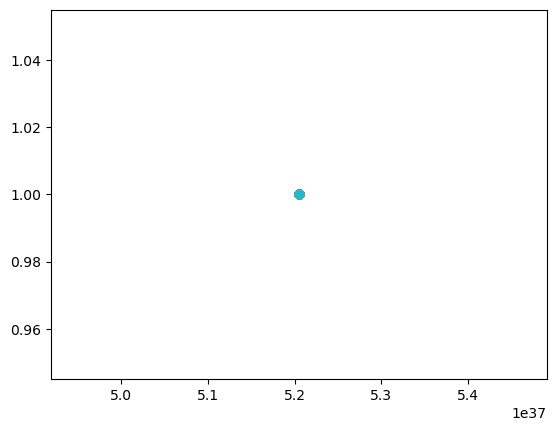

In [54]:
net = CoupledCANN(N=100)
dt = 0.1
T = 100

for t in range(T):
    net.set_input()
    net.step(dt)

cmap = clr.LinearSegmentedColormap.from_list('custom blue', ['#244162','#DCE6F1'], N=T)
S = np.linspace(-np.pi+1, np.pi+1, 150)
fig, ax = plt.subplots()
print(net.ss)
for i in net.ss:
    ax.plot(i[0], [1], 'o-')